# Introduction
- This notebook presents Python code for the algorithm described in https://www.researchgate.net/publication/320864673_A_simple_algorithm_to_find_all_real_roots_of_a_polynomial. Please cite this paper if you use this code or part of it.
- The code finds all real roots of a polynomial and its multiplicities, using standard floating point arithmetics.
- A companion notebook presents Python code for the same algorithm, using mpmath for arbitrary precision arithmetics.
- You may also read the *Fundamentals* notebook in this repository.
- This notebook contains code and tests using some notorious polynomials

# Code
Notes:
- Sympy polynomials and some associated functions are used only for the construction of polynomials for testing, and also for checking correctness of the number or roots found.

## Solver

In [101]:
from collections import OrderedDict

from mpmath import mp, mpf

def sign(value):
    if value < 0:
        return -1
    elif value == 0:
        return 0
    return 1

def degree(p):
    return len(p) - 1

def p_to_str(p):
    
    n = len(p) - 1
    s = str(p[0]) + '*x^' + str(n)

    for i in range(1, n+1):
        if p[i] > 0:
            s += ' + ' + str(p[i]) + '*x^' + str(n-i)
        elif p[i] < 0:
            s += ' - ' + str(-p[i]) + '*x^' + str(n-i)
    
    return s

def derivative(p):
    n = len(p)
    return [p[i]*(n-i-1) for i in range(n-1)]

def evaluate(p, x_value):
    # Using Horner method
    result = mpf(p[0])
    for coef in p[1:]:
        result = result*x_value + mpf(coef)
    return result

def bisection(a, b, tolerance, p, pdiff):
    '''
    Classical bisection method. 
    Raises ValueError when a no progress situation is detected
    pdiff parameter exists only to keep the same signature as other bracketing
    methods, such as Newton-Raphson, that uses the derivative of p
    '''    
    p_a = evaluate(p, a)
    p_b = evaluate(p, b)
    m = (a + b) / 2
    p_m = evaluate(p, m)
    progress = True
    
    iter = 0
    while abs(p_m) > tolerance and progress:
        iter += 1
        old_a, old_b = a, b
        if p_a * p_m <= 0:
            b = m
            p_b = p_m
        elif p_b * p_m <= 0:
            a = m
            p_a = p_m
        m = (a + b) / 2
        p_m = evaluate(p, m)
        if old_a == a and old_b == b:
            progress = False
            raise ValueError(f'bissection: no progress after {iter} iterations\n' 
                             f'while isolating a root of {p_to_str(p)} \nwith \na = {a} \nb = {b}')
    return m

def newton(a, b, tolerance, p, pdiff, maxiter=5000):
    #convergence not guaranteed

    iter = 0
    x_newton = (a + b)/2
    while abs(evaluate(p, x_newton)) > tolerance:
        iter += 1
        if iter >= maxiter:
            raise ValueError(f'newton: no convergence after {iter} iterations')
            break
        x_newton = x_newton - evaluate(p, x_newton)/evaluate(pdiff, x_newton)

    return x_newton

def hibrid( a, b, tolerance, p, pdiff):
    """
    bracketing that mixes Newton-Raphson and Bisection methods.
    Adapted from https://doi.org/10.12988/ams.2017.710302   
    """

    iter = 0
    p_a = evaluate(p, a)
    p_b = evaluate(p, b)
    if p_a * p_b > 0:
        raise ValueError(f'p(a) and p(b) must have opposite signs')
    n_bisec = 0
    n_newton = 0
    m = (a + b)/2
    p_m = evaluate(p, m)
    
    while abs(p_m) > tolerance:
        old_a, old_b = a, b

        iter += 1
        p_m = evaluate(p, m)
        pdiff_m = evaluate(pdiff, m)
        next_x_newton = m - p_m / pdiff_m
        
        if (a < next_x_newton < b): 
            # Take newton guess
            m = next_x_newton
            n_newton += 1
        else:
            # Take bisection guess
            m = (a + b)/2
            n_bisec += 1           
        p_m = evaluate(p, m)
        if p_a * p_m <= 0:
            b = m
            p_b = p_m
        if p_b * p_m <= 0:
            a = m
            p_a = p_m
        if a == old_a and b == old_b:
            raise ValueError(f'hibrid: no progress after {iter} iterations, '
                             f'with \na = {a}\nb = {b}\nm={m} \nb - a = {b - a}'
                             f'\nold_a = {old_a}\nold_b = {old_b}')
            break
    return m

def mpf_internal_root(p, pdiff, roots_dict, derivative_roots_dict,
                      a, b, tolerance, bracketing):

    p_a = evaluate(p, a)
    if abs(p_a) <= tolerance:
        pass
    else:
        p_b = evaluate(p, b)
        if abs(p_b) < tolerance:
            roots_dict[b] = derivative_roots_dict[b] + 1
            # Increment multiplicity
        else:
            sign_at_a = sign(p_a)
            sign_at_b = sign(p_b)
            if sign_at_a == sign_at_b:
                pass
            else:
                roots_dict[bracketing(a, b, tolerance, p, pdiff)] = 1


def mpf_external_root(p, pdiff, roots_dict, derivative_roots_dict,
                  extremity, limit_sign, initial_step, tolerance, bracketing):
    '''
    extremity is the smallest or largest root of pdiff.
    If initial_step < 0, this function will look for a root in interval (-inf, extremity];
    If initial_step > 0, this function will look for a root in interval (extremity, inf)
    '''
    def point_with_sign_inversion(p, extremity, sign_at_extremity, initial_step):

        step = initial_step
        x = extremity + step
        p_x = evaluate(p, x)
        sign_at_x = sign(p_x)

        while sign_at_x == sign_at_extremity:
            step = 2*step # Double step length
            x = x + step
            p_x = evaluate(p, x)
            sign_at_x = sign(p_x)

        return x 

    value_at_extremity = evaluate(p, extremity)
    
    if abs(value_at_extremity) <= tolerance:
        if initial_step < 0:
            roots_dict[extremity] = derivative_roots_dict[extremity] + 1
    else:
        sign_at_extremity = sign(value_at_extremity)
        if limit_sign != sign_at_extremity:
            if initial_step > 0:
                a = extremity
                b = point_with_sign_inversion(p, extremity, 
                                              sign_at_extremity, initial_step)
            else:
                a = point_with_sign_inversion(p, extremity, 
                                              sign_at_extremity, initial_step)
                b = extremity

            roots_dict[bracketing(a, b, tolerance, p, pdiff)] = 1
            # multiplicity = 1

def mpf_roots_from_derivative_roots(p, derivative_roots_dict, tolerance, bracketing):
    '''
    Returns an OrderedDict, with roots as keys and multiplicity as values
    '''
    roots_dict = OrderedDict()
    
    derivative_roots = [r[0] for r in derivative_roots_dict.items()]
    n_derivative_roots = len(derivative_roots)
    pdiff = derivative(p)
       
    if n_derivative_roots == 0:
        # I took 0, but any point should work
        left_extremity = mpf(0)
        right_extremity = mpf(0)
    else:
        left_extremity = derivative_roots[0]
        right_extremity = derivative_roots[-1]
    
    right_limit_sign = sign(p[0]) # p[0]: Leading Coefficient
       
    if degree(p) % 2 == 0:
        left_limit_sign = sign(p[0])
    else:
        left_limit_sign = -sign(p[0]) 
    
    mpf_external_root(p, pdiff, roots_dict, derivative_roots_dict,
                  left_extremity, left_limit_sign, mpf(-1), 
                  tolerance, bracketing)
    
    for i in range(n_derivative_roots - 1): 
        mpf_internal_root(p, pdiff, roots_dict, derivative_roots_dict,
                      derivative_roots[i], derivative_roots[i+1], 
                      tolerance, bracketing)
         
    mpf_external_root(p, pdiff, roots_dict, derivative_roots_dict,
                  right_extremity, right_limit_sign, mpf(1), 
                  tolerance, bracketing)
    
    return roots_dict 

def mpf_find_real_roots(p, tolerance=1.0e-5, bracketing=bisection):
    '''
     Find real roots of polynomial defined by list p
     If the length of p is n+1 then the polynomial is described by:
       p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]
    '''
    roots_dict = OrderedDict()
    
    # print(f'Solving {p_to_str(p)} = 0')

    if len(p) == 2: 
        # first degree polynomial
        roots_dict[-mpf(p[1])/mpf(p[0])] = 1
    else:
        roots_dict = mpf_roots_from_derivative_roots(
            p, mpf_find_real_roots(derivative(p), tolerance, bracketing),
            tolerance, bracketing)

    # print(f'Roots of {p_to_str(p)}: {roots}')
    return roots_dict

## Checking roots

In [2]:
from sympy import Symbol, Poly, rem, LC, Rational
from sympy import degree as sp_degree

x = Symbol('x')

def sign_at_minus_inf(poly):

    if sp_degree(poly) % 2 == 0:
        s = sign(LC(poly, x))
    else:
        s = sign(-LC(poly, x))
        
    return s
    
def sign_at_plus_inf(poly):

    s = sign(LC(poly, x))

    return s

In [3]:
def Sturm(p):
    """
    Returns total number of distinct real roots of p, based on Sturm's theorem
    https://en.wikipedia.org/wiki/Sturm%27s_theorem
    """
    x = Symbol('x')
    poly = Poly(p, x)
    
    minus_inf_sign_inversions = 0
    plus_inf_sign_inversions = 0
    
    last_p = poly.diff()

    if sign_at_minus_inf(poly) != sign_at_minus_inf(last_p):
        minus_inf_sign_inversions += 1
    if sign_at_plus_inf(poly) != sign_at_plus_inf(last_p):
        plus_inf_sign_inversions += 1
        
    last_sign_at_minus_inf = sign_at_minus_inf(last_p)
    last_sign_at_plus_inf = sign_at_plus_inf(last_p)

    while sp_degree(last_p) > 0:
        next_p = -rem(poly, last_p)

        if sign_at_minus_inf(next_p) != last_sign_at_minus_inf:
            minus_inf_sign_inversions += 1
        if sign_at_plus_inf(next_p) != last_sign_at_plus_inf:
            plus_inf_sign_inversions += 1
        poly = last_p
        last_p = next_p
        last_sign_at_minus_inf = sign_at_minus_inf(last_p)
        last_sign_at_plus_inf = sign_at_plus_inf(last_p)        
        
    return minus_inf_sign_inversions - plus_inf_sign_inversions

In [4]:
def check_roots(p, roots_dict, tolerance):
    
    roots = [r[0] for r in roots_dict.items()]
    
    # Are all elements of roots distinct and in ascending order?
    for i in range(len(roots) - 1):
        if roots[i] >= roots[i + 1]:
            raise ValueError(f'roots[{i}] is >= roots[{i + 1}]')
    print(f'\ncheck_roots: all roots are distinct and in order')
    # For all r in roots, abs(p(r)) <= tolerance?

    for r in roots:
        if abs(evaluate(p, r)) > tolerance:
            raise ValueError(f'abs(p({r})) = {abs(evaluate(p, r))} > {tolerance}')
    print(f'check_roots: all roots are roots within tolerance')
    # Number of elements of roots equals Sturm(p)?
    n_roots_Sturm = Sturm(p)
    if len(roots) != n_roots_Sturm:
        print(f">>> ERROR: Only {len(roots)} real roots found; "
                         f"{n_roots_Sturm} real roots were expected by Sturm's theorem.")
    else:
        print(f"check_roots: number of real roots, {n_roots_Sturm},"
              " as expected by Sturm's theorem")

## Ploting polynomials and printing roots dict

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_p(p, xlim):
    """
    Plots a polynomial
    """
    x_values = np.linspace(xlim[0], xlim[1], 200)
    #print(f'v = {v}')
    y_p = [evaluate(p, v) for v in x_values]
    
    ax = plt.gca()

    plt.gcf().text(0.02, -0.1, '$' + p_to_str(p) + '$', fontsize=11)
    

    ax.plot(x_values, y_p, 'b')

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    
    plt.show()

In [58]:
def print_roots_dict(p, roots_dict):
    print(f'\nReal roots of p(x) =\n{p_to_str(p)}')
    roots = [r[0] for r in roots_dict.items()]
    for i, r in enumerate(roots):
        print(f'Root[{i}] (x {roots_dict[r]}) = \n  {r}')

# Tests

In [105]:
import time

## Polynomials with known roots
- Knowing the roots makes testing easier

In [6]:
def poly_from_roots(poly_roots, constant=Rational(1)):
    """
    Constructs a polynomial from a list of is roots. 
    If poly_roots contains a complex number, its conjugate will be included too.
    """
    x = Symbol('x')
    W = constant
    for r in poly_roots:
        if isinstance(r, complex):
            a = Rational(r.real)
            b = Rational(r.imag)
            W = W * (a**2 - 2*a*x + b**2 + x**2)
        else:
            W = W * (x - Rational(r))
    return [int(coef) for coef in Poly(W).all_coeffs()]

### A polynomial with 4 real roots

1*x^4 - 10*x^3 + 17*x^2 + 40*x^1 - 84*x^0


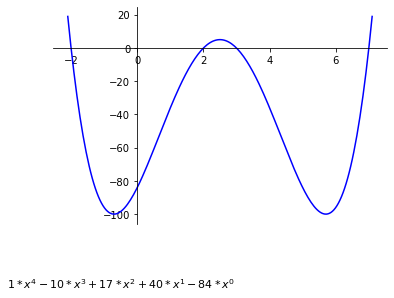

In [102]:
p = poly_from_roots([3, 2, -2, 7])
print(p_to_str(p))
plot_p(p, [-2.1, 7.1])

In [91]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=bisection)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^4 - 10*x^3 + 17*x^2 + 40*x^1 - 84*x^0
Root[0] (x 1) = 
  -2.0
Root[1] (x 1) = 
  2.0000000000000000000000000000000000000043500843738
Root[2] (x 1) = 
  2.9999999999999999999999999999999999999956499156262
Root[3] (x 1) = 
  7.0


In [94]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=newton)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^4 - 10*x^3 + 17*x^2 + 40*x^1 - 84*x^0
Root[0] (x 1) = 
  -2.0
Root[1] (x 1) = 
  1.9999999999999999999999999999999999999999999988336
Root[2] (x 1) = 
  3.0000000000000000000000000000000000000000000011664
Root[3] (x 1) = 
  7.0


In [103]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=hibrid)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^4 - 10*x^3 + 17*x^2 + 40*x^1 - 84*x^0
Root[0] (x 1) = 
  -2.0
Root[1] (x 1) = 
  1.9999999999999999999999999999999999999999999988336
Root[2] (x 1) = 
  3.0000000000000000000000000000000000000000000011664
Root[3] (x 1) = 
  7.0


In [12]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 4, as expected by Sturm's theorem


### A polynomial with real  and complex roots

1*x^8 + -70*x^7 + 1126*x^6 + 25210*x^5 + -88631*x^4 + -1622840*x^3 + 4914444*x^2 + 6092480*x^1 + -18312000


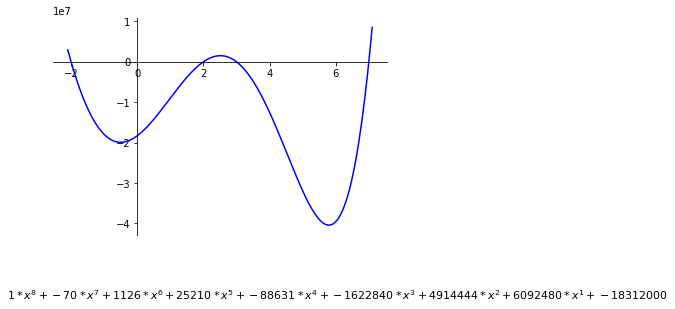

In [56]:
p = poly_from_roots([3, 2, -2, 7, 40 + 20j, -10 -3j])
print(p_to_str(p))
plot_p(p, [-2.1, 7.1])

In [59]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=bisection)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^8 + -70*x^7 + 1126*x^6 + 25210*x^5 + -88631*x^4 + -1622840*x^3 + 4914444*x^2 + 6092480*x^1 + -18312000
Root[0] (x 1) = 
  -1.9999999999999999999999999999999999999999999972017
Root[1] (x 1) = 
  2.0000000000000000000000000000000000000000000086273
Root[2] (x 1) = 
  2.9999999999999999999999999999999999999999999878341
Root[3] (x 1) = 
  7.0000000000000000000000000000000000000000000003787


In [16]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 4, as expected by Sturm's theorem


### A polynomial with only complex roots

1*x^8 + -20*x^7 + 200*x^6 + -1200*x^5 + 4708*x^4 + -12080*x^3 + 20000*x^2 + -19200*x^1 + 9216


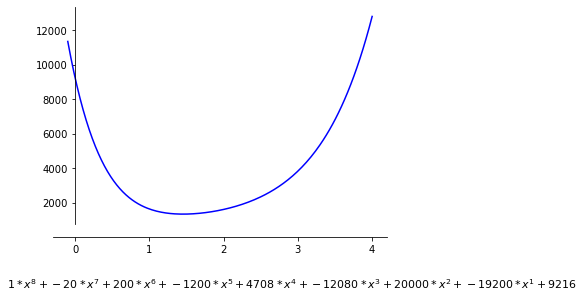

In [60]:
p = poly_from_roots([1 + 1j, 2 + 2j, 3 + 3j, 4 + 4j])
print(p_to_str(p))
plot_p(p, [-0.1, 4])

In [62]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=bisection)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^8 + -20*x^7 + 200*x^6 + -1200*x^5 + 4708*x^4 + -12080*x^3 + 20000*x^2 + -19200*x^1 + 9216


In [63]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 0, as expected by Sturm's theorem


### A polynomial with roots with multiplicity

1*x^9 + -25*x^8 + 258*x^7 + -1430*x^6 + 4661*x^5 + -9261*x^4 + 11320*x^3 + -8308*x^2 + 3360*x^1 + -576


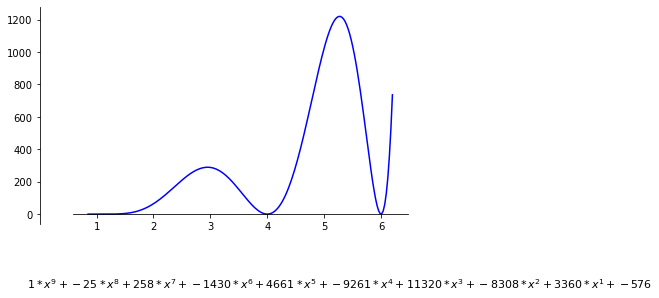

In [66]:
p = poly_from_roots([1]*5  + [4, 6]*2)
print(p_to_str(p))
plot_p(p, [0.85, 6.2])

In [65]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=bisection)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^9 + -25*x^8 + 258*x^7 + -1430*x^6 + 4661*x^5 + -9261*x^4 + 11320*x^3 + -8308*x^2 + 3360*x^1 + -576
Root[0] (x 5) = 
  1.0000000000000000000000000000000000000000007971831
Root[1] (x 2) = 
  3.9999999999999999999999999999999999999999746206026
Root[2] (x 2) = 
  6.0000000000000000000000000000000000000000007971831


In [67]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 3, as expected by Sturm's theorem


### Wilkinson polynomials

In [68]:
def Wilkinson(n):
    return poly_from_roots(list(range(1,n+1)))

1*x^10 - 55*x^9 + 1320*x^8 - 18150*x^7 + 157773*x^6 - 902055*x^5 + 3416930*x^4 - 8409500*x^3 + 12753576*x^2 - 10628640*x^1 + 3628800*x^0


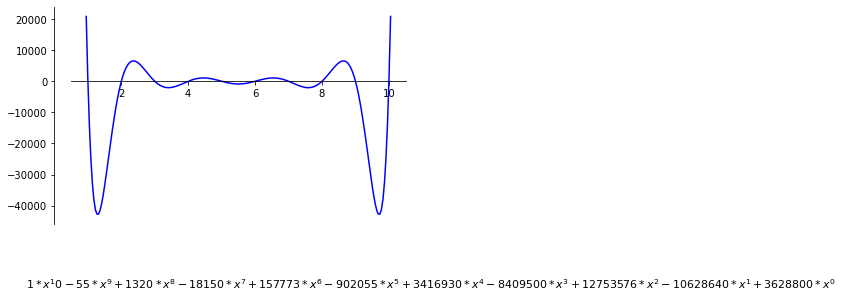

In [87]:
p = Wilkinson(10)
print(p_to_str(p))
plot_p(p, [0.95, 10.05])

In [70]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 50
roots_dict = mpf_find_real_roots(p, tolerance=tolerance)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^10 + -55*x^9 + 1320*x^8 + -18150*x^7 + 157773*x^6 + -902055*x^5 + 3416930*x^4 + -8409500*x^3 + 12753576*x^2 + -10628640*x^1 + 3628800
Root[0] (x 1) = 
  0.99999999999999999999999999999999999999999995515845
Root[1] (x 1) = 
  1.9999999999999999999999999999999999999999990967581
Root[2] (x 1) = 
  2.9999999999999999999999999999999999999999976325881
Root[3] (x 1) = 
  4.0000000000000000000000000000000000000000194851892
Root[4] (x 1) = 
  4.9999999999999999999999999999999999999999831240308
Root[5] (x 1) = 
  6.0000000000000000000000000000000000000000168759692
Root[6] (x 1) = 
  6.9999999999999999999999999999999999999999805148107
Root[7] (x 1) = 
  8.0000000000000000000000000000000000000000023674119
Root[8] (x 1) = 
  9.0000000000000000000000000000000000000000009032418
Root[9] (x 1) = 
  10.000000000000000000000000000000000000000000044842


In [71]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 10, as expected by Sturm's theorem


In [113]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 200
p = Wilkinson(50)
start = time.perf_counter()
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=bisection)
end = time.perf_counter()
print(f'Time elapsed: {end - start}')
print_roots_dict(p, roots_dict)

Time elapsed: 160.1713232999973

Real roots of p(x) =
1*x^50 - 1275*x^49 + 791350*x^48 - 318622500*x^47 + 93570498490*x^46 - 21366198225750*x^45 + 3949131291964600*x^44 - 607317906105487500*x^43 + 79274383168492884295*x^42 - 8916311500907225617125*x^41 + 874274440470458637491350*x^40 - 75430949131153796097540000*x^39 + 5769557497517595816762422380*x^38 - 393625378247020213038955570500*x^37 + 24074634262098477202456261501600*x^36 - 1325513314288519699308436238355000*x^35 + 65926306456751344865378122278650335*x^34 - 2970483623265905855449410614694043125*x^33 + 121537997067927371629961551678685914850*x^32 - 4524229387507572623070958774667674282500*x^31 + 153457012425237702675940309806097247177498*x^30 - 4748411888781425210165280179331840887560950*x^29 + 134153032410638239369309397211318138160939400*x^28 - 3462458978207366446890224680162408296258877500*x^27 + 81661954970720573655661780303655361431161958585*x^26 - 1759975170237895559117007667844300114185022044875*x^25 + 34652078765044198452

In [111]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 200
p = Wilkinson(50)
start = time.perf_counter()
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=newton)
end = time.perf_counter()
print(f'Time elapsed: {end - start}')
print_roots_dict(p, roots_dict)

Time elapsed: 10.878564099999494

Real roots of p(x) =
1*x^50 - 1275*x^49 + 791350*x^48 - 318622500*x^47 + 93570498490*x^46 - 21366198225750*x^45 + 3949131291964600*x^44 - 607317906105487500*x^43 + 79274383168492884295*x^42 - 8916311500907225617125*x^41 + 874274440470458637491350*x^40 - 75430949131153796097540000*x^39 + 5769557497517595816762422380*x^38 - 393625378247020213038955570500*x^37 + 24074634262098477202456261501600*x^36 - 1325513314288519699308436238355000*x^35 + 65926306456751344865378122278650335*x^34 - 2970483623265905855449410614694043125*x^33 + 121537997067927371629961551678685914850*x^32 - 4524229387507572623070958774667674282500*x^31 + 153457012425237702675940309806097247177498*x^30 - 4748411888781425210165280179331840887560950*x^29 + 134153032410638239369309397211318138160939400*x^28 - 3462458978207366446890224680162408296258877500*x^27 + 81661954970720573655661780303655361431161958585*x^26 - 1759975170237895559117007667844300114185022044875*x^25 + 3465207876504419845

In [110]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 200
p = Wilkinson(50)
start = time.perf_counter()
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=hibrid)
end = time.perf_counter()
print(f'Time elapsed: {end - start}')
print_roots_dict(p, roots_dict)

Time elapsed: 12.047008300003654

Real roots of p(x) =
1*x^50 - 1275*x^49 + 791350*x^48 - 318622500*x^47 + 93570498490*x^46 - 21366198225750*x^45 + 3949131291964600*x^44 - 607317906105487500*x^43 + 79274383168492884295*x^42 - 8916311500907225617125*x^41 + 874274440470458637491350*x^40 - 75430949131153796097540000*x^39 + 5769557497517595816762422380*x^38 - 393625378247020213038955570500*x^37 + 24074634262098477202456261501600*x^36 - 1325513314288519699308436238355000*x^35 + 65926306456751344865378122278650335*x^34 - 2970483623265905855449410614694043125*x^33 + 121537997067927371629961551678685914850*x^32 - 4524229387507572623070958774667674282500*x^31 + 153457012425237702675940309806097247177498*x^30 - 4748411888781425210165280179331840887560950*x^29 + 134153032410638239369309397211318138160939400*x^28 - 3462458978207366446890224680162408296258877500*x^27 + 81661954970720573655661780303655361431161958585*x^26 - 1759975170237895559117007667844300114185022044875*x^25 + 3465207876504419845

In [97]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 50, as expected by Sturm's theorem


##  Mignotte polynomials

In [74]:
def Mignotte(n, tau):
    x = Symbol('x')
    return [int(coef) for coef in Poly((x**n - ((2**(tau//2) - 1)*x - 1)**2)).all_coeffs()]

1*x^7 - 9*x^2 + 6*x^1 - 1*x^0


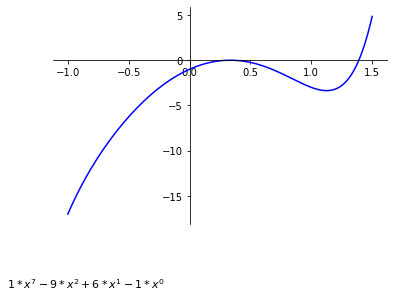

In [88]:
p = Mignotte(7, 4)
print(p_to_str(p))
plot_p(p, (-1, 1.5))

In [76]:
tolerance = mp.mpf('1.0e-37')
mp.dps = 200
roots_dict = mpf_find_real_roots(p, tolerance=tolerance)
print_roots_dict(p, roots_dict)


Real roots of p(x) =
1*x^7 + 0*x^6 + 0*x^5 + 0*x^4 + 0*x^3 + -9*x^2 + 6*x^1 + -1
Root[0] (x 1) = 
  0.326690454897132029623508914833692361555326442240339469182800424884368581226271436400020349577477674074543756432831287384033203125
Root[1] (x 1) = 
  0.34105602675329680119577817102715021555346126759455449273237473010833870826689204437383204319447665213122511343390809182804681352815836018563670733317114590807740943971822565981850853116338926336645451
Root[2] (x 1) = 
  1.390743647321061451053363441530781275884396417208327878426361780166178255686404377719782472777598769653195631690323352813720703125


In [77]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 3, as expected by Sturm's theorem


In [109]:
n = 513
tau = 14
p = Mignotte(n, tau)
tolerance = mp.mpf('1.0e-1500')
mp.dps = 1750
start = time.perf_counter()
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=bisection)
end = time.perf_counter()
print(f'Time elapsed: {end - start}')
print_roots_dict(p, roots_dict)

Time elapsed: 372.3692063999988

Real roots of p(x) =
1*x^513 - 16129*x^2 + 254*x^1 - 1*x^0
Root[0] (x 1) = 
  0.00787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196850393700787401574803149606299212598425196848529288940651142928544772422222839202410418958519469468018189202139355227133306254214215968899952256927104451516004100980227516259737712941254385295693487029028629797442213173329975823899461122221311773870783335769499335387968717034867616580312687991022809983046476652061991066595745223776867345277495801927418266161194782930170668920794523985521

In [106]:
n = 513
tau = 14
p = Mignotte(n, tau)
tolerance = mp.mpf('1.0e-1500')
mp.dps = 1750
start = time.perf_counter()
roots_dict = mpf_find_real_roots(p, tolerance=tolerance, bracketing=hibrid)
end = time.perf_counter()
print(f'Time elapsed: {end - start}')
print_roots_dict(p, roots_dict)

Time elapsed: 186.06359570000495

Real roots of p(x) =
1*x^513 - 16129*x^2 + 254*x^1 - 1*x^0
Root[0] (x 1) = 
  0.0078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519685039370078740157480314960629921259842519684852928894065114292854477242222283920241041895851946946801818920213935522713330625421421596889995225692710445151600410098022751625973771294125438529569348702902862979744221317332997582389946112222131177387078333576949933538796871703486761658031268799102280998304647665206199106659574522377686734527749580192741826616119478293017066892079452398552

In [107]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 3, as expected by Sturm's theorem


## Chebyshev polynomials of first kind

In [44]:
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

@memoize
def Chebyshev(n):
    x = Symbol('x')
    if n == 0:
        return 1
    elif n == 1:
        return x
    else:
        return (2*x*Chebyshev(n-1) - Chebyshev(n-2)).expand()

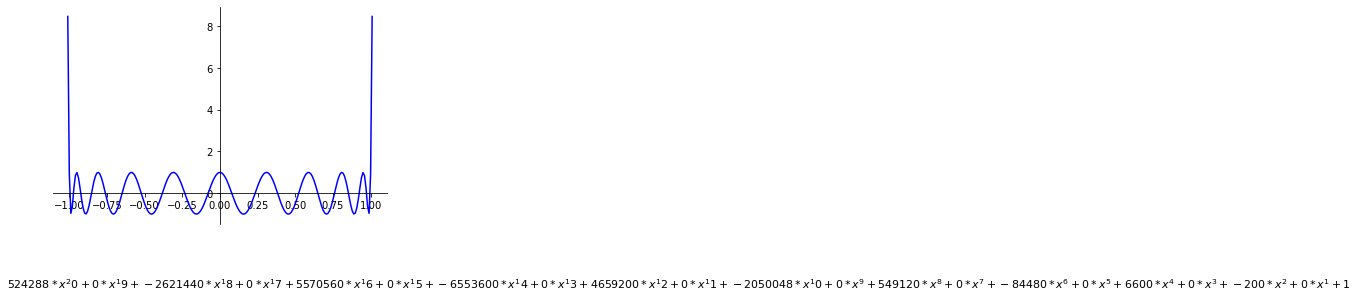

OrderedDict([(mpf('-0.9969173337331279761977734087420444201589954782921085059669228481078271995794608815549780810410927632107119302813462675971591988186695278145983810404256073261879123048601059053908102214336395263671875'),
              1),
             (mpf('-0.97236992039767660183364583411879764400309393375185438330717353746653803522801178081517949638780600532623937185148348404456222489541131849297572535189505834534814377036123592130285838666487381253709341437'),
              1),
             (mpf('-0.92387953251128675612818318939678828682267634462764362957013443002733115545794155340872404325101775942259693472547288321611354010084971639143280365427246582283127244565998473352007002232715148845865311653'),
              1),
             (mpf('-0.85264016435409222151938345813041213581914902666624008535183427954715072862345037109638619418892751754136879262522413213287893777759009644989706359249234020817908169818013217524410300334594160520732920063'),
              1),
             (mp

In [47]:
p = [int(coef) for coef in Poly(Chebyshev(20)).all_coeffs()]
plot_p(p, (-1.01, 1.01))
tolerance = mp.mpf('1.0e-37')
mp.dps = 200
roots_dict = mpf_find_real_roots(p, tolerance=tolerance)
roots_dict

In [48]:
check_roots(p, roots_dict, tolerance)


check_roots: all roots are distinct and in order
check_roots: all roots are roots within tolerance
check_roots: number of real roots, 20, as expected by Sturm's theorem
